In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:80% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li, code{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

In [9]:
import os # 모델 저장할 폴더가 있는지 여부와 폴더 생성
import numpy as np
import pandas as pd # get_dummies(원핫인코딩), crosstab
import seaborn as sns # iris 데이터(데이터프레임) 가져오기
from sklearn import datasets # iris 데이터(X, y) 가져오기
from sklearn.preprocessing import LabelEncoder # 라벨인코더
from tensorflow.keras.utils import to_categorical # 원핫인코딩 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras import metrics # compile
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [20]:
import seaborn as sns
iris = sns.load_dataset('iris')

In [21]:
from sklearn import datasets
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [22]:
X_iris = iris.iloc[:, :-1].values # to_numpy와 유사. numpy배열로
y_iris = iris.iloc[:, -1] #3,4,5,6,7,8
X_iris.shape, y_iris.shape

((150, 4), (150,))

- 데이터 셋 생성(seaborn) & 전처리
    X, y(라벨인코딩-원핫인코딩)분리 -> train과 test셋 분리
- 모델 구성(입력 4 -> 출력3, layer5: 4->64->128->50->30->3)
- 모델 학습과정 설정
- 모델 학습(Earlystopping, ModelCheckpoint추가)
- 모델평가(시각화, 현재모델과 저장딘 최고의 모델 평가, 교차표==혼동행렬)
- 모델예측/저장

In [ ]:
X_iris = iris.iloc[:, :-1].values # to_numpy와 유사. numpy배열로
y_iris = iris.iloc[:, -1] #3,4,5,6,7,8
X_iris.shape, y_iris.shape


In [23]:
# 독립변수 X의 스케일 조정
scaler = StandardScaler()
scaler.fit(X_iris)
scaled_X_iris = scaler.transform(X_iris)

# 다중분류를 위한 타겟변수의 원핫인코딩 -> numpy 배열로 변환

Y_iris = pd.get_dummies(y_iris).to_numpy()

In [25]:
# Y_iris

In [87]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X_iris,
                                                   Y_iris,
                                                   test_size=0.2,
                                                   train_size=0.8,
                                                   stratify=Y_iris, # 층화
                                                   random_state=12
                                                   )
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((120, 4), (120, 3), (30, 4), (30, 3))

In [88]:
#모델 구성(입력 4 -> 출력3, layer5: 4->64->128->50->30->3)

In [89]:
model = Sequential()
model.add(Input(4))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=50, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units=30, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                320       
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 128)               8320      
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 50)                6450      
                                                                 
 dropout_19 (Dropout)        (None, 50)                0         
                                                                 
 dense_33 (Dense)            (None, 30)               

In [90]:
%%time
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

class CustomHistory(Callback): # on_epoch_end()함수가 epoch수행후 자동 호출
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if (self.epoch%5 == 0) | (self.epoch==1):
            print('{}번째 loss:{:.4f}, acc:{:.4f}, val_loss:{:.4f}, val_acc:{:.4f}'\
                  .format(self.epoch,
                         logs.get('loss'),
                         logs.get('accuracy'),
                         logs.get('val_loss'),
                         logs.get('val_accuracy')
                )
            )
model_save_folder = './model/'
import os
if not os.path.exists(model_save_folder): # 폴더 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder \
        + 'wine-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
# 콜백 객체
customHistory = CustomHistory()
checkpoint = ModelCheckpoint(
                    filepath=file,
                    monitor='val_accuracy', # 모니터링 지표:loss, val_loss, accuracy
                    save_best_only=True,    # 모니터링 지표가 개선된 경우만 저장
                    mode = 'max',
                    verbose=0) # 로그 출력 여부
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)
# 학습
hist = model.fit(X_train, Y_train, epochs=200, batch_size=200,
                validation_split=0.2, # 학습셋의 20%는 검증셋으로 
                verbose=0, # 로그출력 막음(콜백함수에서 출력)
                callbacks=[earlyStopping,
                          customHistory,
                          checkpoint])

1번째 loss:1.0955, acc:0.2917, val_loss:1.0499, val_acc:0.6667
5번째 loss:0.9669, acc:0.6875, val_loss:0.8961, val_acc:0.8333
10번째 loss:0.8067, acc:0.7917, val_loss:0.7108, val_acc:0.8333
15번째 loss:0.6253, acc:0.7917, val_loss:0.5490, val_acc:0.8333
20번째 loss:0.5199, acc:0.8125, val_loss:0.4355, val_acc:0.8750
25번째 loss:0.4310, acc:0.8229, val_loss:0.3701, val_acc:0.9167
30번째 loss:0.3718, acc:0.8854, val_loss:0.3097, val_acc:0.9583
35번째 loss:0.3154, acc:0.8646, val_loss:0.2543, val_acc:0.9583
40번째 loss:0.3101, acc:0.8854, val_loss:0.2262, val_acc:0.9583
45번째 loss:0.2722, acc:0.8646, val_loss:0.1984, val_acc:0.9583
50번째 loss:0.1867, acc:0.9375, val_loss:0.1937, val_acc:0.9583
55번째 loss:0.1507, acc:0.9479, val_loss:0.1793, val_acc:0.9583
60번째 loss:0.1422, acc:0.9375, val_loss:0.1703, val_acc:0.9583
65번째 loss:0.1458, acc:0.9688, val_loss:0.1594, val_acc:0.9583
70번째 loss:0.1475, acc:0.9271, val_loss:0.1575, val_acc:0.9583
75번째 loss:0.1289, acc:0.9375, val_loss:0.1879, val_acc:0.9583
80번째 loss:

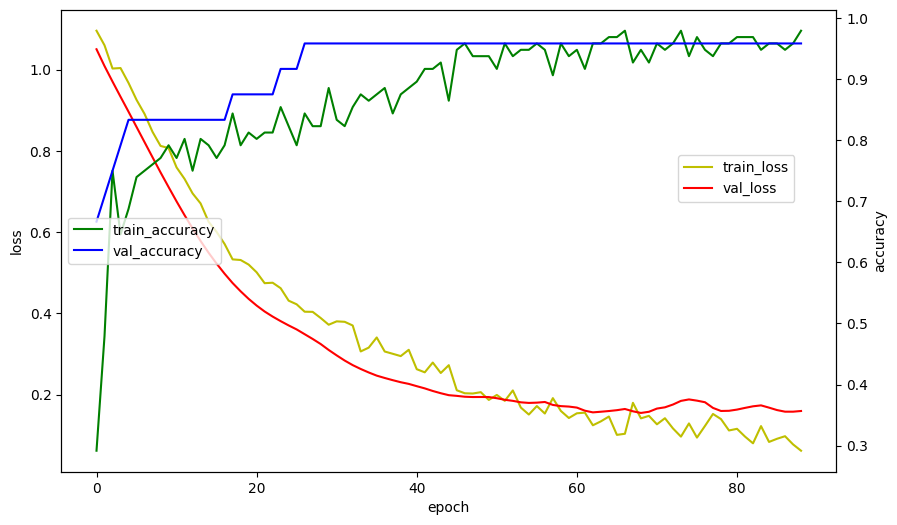

In [91]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center left')
plt.show()

In [92]:
loss_and_acc = model.evaluate(X_test, Y_test, batch_size = 100, verbose = 0)

print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')


loss:0.1960, accuracy:0.9667


In [93]:
real = Y_test.argmax(axis=1)  # 실제값
# real = np.argmax(Y_test, axis=1)
pred = model.predict(X_test).argmax(axis=1) 


pd.crosstab(real, pred, rownames=['real'], colnames=['predict'])

1/1 [==============================] - 0s 51ms/step


predict,0,1,2
real,,,
0,10,0,0
1,0,10,0
2,0,1,9


In [94]:
input_data = [5.1, 3.5 ,1.4 ,0.2]

In [95]:
model.predict([input_data]).argmax(axis=1)

1/1 [==============================] - 0s 29ms/step


array([1], dtype=int64)

In [96]:
model2 = load_model('model/wine-088-loss1.0014-acc0.5938.h5')
loss_and_acc1 = model2.evaluate(X_test, Y_test, verbose = 0)

print(f'loss:{loss_and_acc1[0]:.4f}, accuracy:{loss_and_acc1[1]:.4f}')

ValueError: in user code:

    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 11), found shape=(None, 4)
